# Real or Fake? Using Machine Learning to predict fake news
In this project we are using machine learning to determine if it can detect fake or real news. We have a dataframe that consists of variables such as xyz

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest, f_regression, f_classif

In [3]:
df = pd.read_csv("fake_news_dataset.csv") #reading the dataset 

# Standardize to lowercase strings if needed
df['label'] = df['label'].map({'Real': 0, 'Fake': 1})

In [4]:
print(df.columns)
df.head(3)

Index(['id', 'title', 'author', 'text', 'state', 'date_published', 'source',
       'category', 'sentiment_score', 'word_count', 'char_count', 'has_images',
       'has_videos', 'readability_score', 'num_shares', 'num_comments',
       'political_bias', 'fact_check_rating', 'is_satirical', 'trust_score',
       'source_reputation', 'clickbait_score', 'plagiarism_score', 'label'],
      dtype='object')


,id,title,author,text,state,date_published,source,category,sentiment_score,word_count,...,num_shares,num_comments,political_bias,fact_check_rating,is_satirical,trust_score,source_reputation,clickbait_score,plagiarism_score,label
0,1,Breaking News 1,Jane Smith,This is the content of article 1. It contains ...,Tennessee,30-11-2021,The Onion,Entertainment,-0.22,1302,...,47305,450,Center,FALSE,1,76,6,0.84,53.35,1
1,2,Breaking News 2,Emily Davis,This is the content of article 2. It contains ...,Wisconsin,02-09-2021,The Guardian,Technology,0.92,322,...,39804,530,Left,Mixed,1,1,5,0.85,28.28,1
2,3,Breaking News 3,John Doe,This is the content of article 3. It contains ...,Missouri,13-04-2021,New York Times,Sports,0.25,228,...,45860,763,Center,Mixed,0,57,1,0.72,0.38,1


The first question we want to solve is: <b>1) Which state might be populated with the most fake news ?</b> <br>
we want to do this by filtering fake news, along with states that they are located in

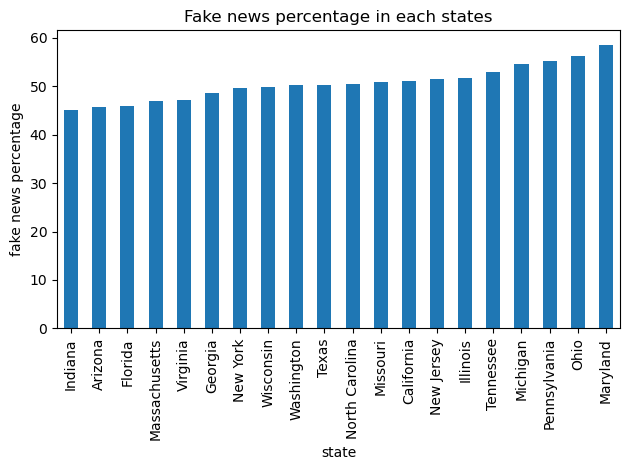

In [6]:
### The reason why to use percentage rather than counts of fake news in each states is that 
### there could be situation that the numbers of news collected from each state are different
### So it is "unfair" if we simply use counts of fake news
state_fake_news_percentage = df.groupby("state")["label"].mean()*100
state_fake_news_percentage = state_fake_news_percentage.sort_values(ascending = True)

state_fake_news_percentage.plot(kind = "bar")
plt.ylabel("fake news percentage")
plt.title("Fake news percentage in each states")
plt.tight_layout()
plt.show()

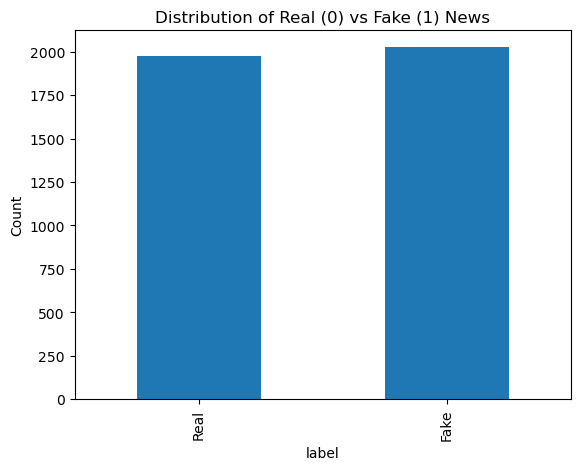

In [7]:
#Ensure that we have balanced dataset by showing the counts of fake and real news
counts_fake_real = df.groupby("label").size()
counts_fake_real.plot(kind ="bar")
plt.title("Distribution of Real (0) vs Fake (1) News")
plt.xlabel("label")
plt.ylabel("Count")
plt.xticks([0, 1], ['Real', 'Fake'])
plt.show()

As you can see, Maryland has the most fake news in this dataset, as we organize from lowest to highest. We want to answer other questions that are more interesting, and could lead us into finding something new to discover. The next cell, we want to use machine learning to help find fake or real news, so we will do some testing

In [9]:
#Choose features that would potentially give us the best results based on their definitions
#1. Remove features that have similar definitions to others': "char_count", "source"
#2. Remove features that are too hard to analyze or useless: "id", "title", "author", "text", "data_published"
selected = [#'id', 
    #'title', 
    #'author', 
    #'text', 
    'state', 
    #'date_published', 
    #'source',
    'category', 
    'sentiment_score', 
    'word_count', 
    #'char_count', 
    'has_images',
    'has_videos', 
    'readability_score', 
    'num_shares', 
    'num_comments',
    'political_bias', 
    'fact_check_rating', 
    'is_satirical', 
    'trust_score',
    'source_reputation', 
    'clickbait_score', 
    'plagiarism_score',
    'label']
# len(selected)

In [10]:
df_selected = df[selected].copy()

### Encode categorical features: "state", "category", "political_bias", "fact_check_rating"
### we don't need to One-hot encode 'has_images' and 'has_videos' since they are already binary

# For "state", we use the proportion of fake news in each states to represent each states
# For example, if 70% of news collected from WI is fake, WI is assigned as 0.7
# we use this method rather than "LabelEncoder"
# The reason is that if we use LabelEncoder, like(Wisconsin = 1, Florida = 2, California = 3 and so on),
# in linear model, such as logistic regression and SVM, this encoding may mislead the model into thinking that 
# there's an order that California > Florida > Wisconsin in estimating the probability of fake news, but this may not be true
state_fake_proportion = df_selected.groupby("state")["label"].mean()
df_selected["state"] = df_selected["state"].map(state_fake_proportion)

# We use LabelEncoder for "category", "political_bias", "fact_check_rating"
# Since in these categorical features, the proportions of fake news of different values are roughly equal
#le_state = LabelEncoder()
le_category = LabelEncoder()
le_political_bias = LabelEncoder()
le_fact_check_rating = LabelEncoder()  #these are label encoding because percentage of fake news are almost equal

#df_selected['state'] = le_state.fit_transform(df_selected['state'])        
df_selected['category'] = le_category.fit_transform(df_selected['category'])
df_selected['political_bias'] = le_political_bias.fit_transform(df_selected['political_bias'])
df_selected['fact_check_rating'] = le_fact_check_rating.fit_transform(df_selected['fact_check_rating'])


X = df_selected[selected]
y = df_selected['label']


df_selected.head(3) #preview of what we have after removing variables and encoding them

,state,category,sentiment_score,word_count,has_images,has_videos,readability_score,num_shares,num_comments,political_bias,fact_check_rating,is_satirical,trust_score,source_reputation,clickbait_score,plagiarism_score,label
0,0.528796,1,-0.22,1302,0,0,66.18,47305,450,0,0,1,76,6,0.84,53.35,1
1,0.497537,5,0.92,322,1,0,41.10,39804,530,1,1,1,1,5,0.85,28.28,1
2,0.508197,4,0.25,228,0,1,30.04,45860,763,0,1,0,57,1,0.72,0.38,1


In [11]:
# #we do feature selection here to choose the best variables to test our model on
# selector = SelectKBest(score_func=f_regression, k=8)
# X_new = selector.fit_transform(X=X, y=y)[0:3, :]

# selected_features = selector.get_support()
# X_features = X[X.columns[selected_features]]
# X_features.head(2)

These are the variables that are most relevant to us in the dataset according to feature selection.

In [13]:
features = [#'id', 
    #'title', 
    #'author', 
    #'text', 
    # 'state', 
    #'date_published', 
    #'source',
    # 'category', 
    'sentiment_score', 
    'word_count', 
    #'char_count', 
    # 'has_images',
    # 'has_videos', 
    'readability_score', 
    'num_shares', 
    'num_comments',
    # 'political_bias', 
    # 'fact_check_rating', 
    'is_satirical', 
    'trust_score',
    'source_reputation', 
    # 'clickbait_score', 
    'plagiarism_score',
    ]   #we wanna keep SVM LR because these models both use numerical values when it comes to accuracy IF we choose to choose variables manually

X = df[features]
y = df['label']

In [14]:
#temp set
# X_train, X_temp, y_train, y_temp = train_test_split(X_features, y, test_size=0.2, random_state=42)

# # Split the temporary set into validation and test sets
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
# --------------------------------------------------------------------------------------------------------------
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
# -----------------------------------------------------------------------------

# Define classifiers and their hyperparameters
models = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000),
        'params': {
            'model__C': [0.01, 0.1, 1, 10]
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'model__max_depth': [3, 5, 10, None],
            'model__min_samples_split': [2, 5, 10]
        }
    },
    'SVM': {
        'model': SVC(),
        'params': {
            'model__C': [0.1, 1, 10],
            'model__kernel': ['linear', 'rbf']
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'model__n_neighbors': [3, 5, 7, 9]
        }
    }
}

# Store results
results = []

# Iterate over classifiers
for name, clf in models.items():
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', clf['model'])
    ])
    
    grid = GridSearchCV(pipe, clf['params'], cv=5, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_val)
    
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    results.append({
        'Model': name,
        'Best Params': grid.best_params_,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    })
    
    print(f"\n{name} — Best Parameters: {grid.best_params_}")
    print(classification_report(y_val, y_pred, digits=3))

# Create a summary table
results_df = pd.DataFrame(results)
print("\nModel Performance Summary:\n")


results_df['F1-Score'] = results_df['F1-Score'].round(3)
print(results_df.sort_values(by='F1-Score', ascending=False).round({'Accuracy': 3, 'Precision': 3, 'Recall': 3, 'F1-Score': 3}))


Logistic Regression — Best Parameters: {'model__C': 0.01}
              precision    recall  f1-score   support

           0      0.496     0.314     0.385       194
           1      0.520     0.699     0.596       206

    accuracy                          0.512       400
   macro avg      0.508     0.507     0.491       400
weighted avg      0.508     0.512     0.494       400


Decision Tree — Best Parameters: {'model__max_depth': 3, 'model__min_samples_split': 2}
              precision    recall  f1-score   support

           0      0.521     0.696     0.596       194
           1      0.582     0.398     0.473       206

    accuracy                          0.542       400
   macro avg      0.551     0.547     0.534       400
weighted avg      0.552     0.542     0.532       400


SVM — Best Parameters: {'model__C': 0.1, 'model__kernel': 'rbf'}
              precision    recall  f1-score   support

           0      0.556     0.026     0.049       194
           1      0.517

Here is a confusion matrix that shows more information on which model would give us more accuracy


Logistic Regression — Best Parameters: {'model__C': 0.01}
              precision    recall  f1-score   support

           0      0.496     0.314     0.385       194
           1      0.520     0.699     0.596       206

    accuracy                          0.512       400
   macro avg      0.508     0.507     0.491       400
weighted avg      0.508     0.512     0.494       400



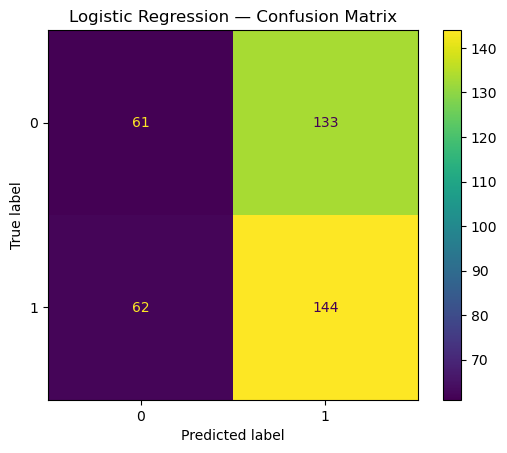


Decision Tree — Best Parameters: {'model__max_depth': 3, 'model__min_samples_split': 2}
              precision    recall  f1-score   support

           0      0.521     0.696     0.596       194
           1      0.582     0.398     0.473       206

    accuracy                          0.542       400
   macro avg      0.551     0.547     0.534       400
weighted avg      0.552     0.542     0.532       400



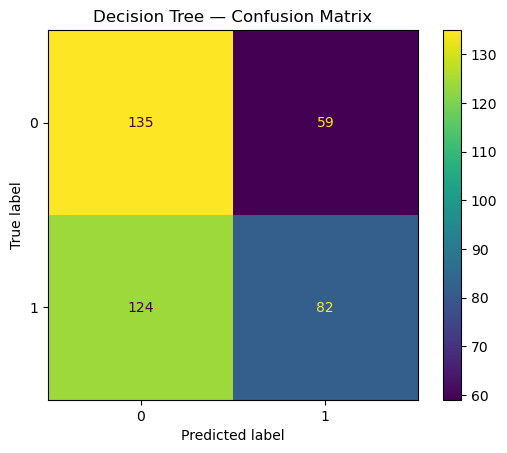


SVM — Best Parameters: {'model__C': 0.1, 'model__kernel': 'rbf'}
              precision    recall  f1-score   support

           0      0.556     0.026     0.049       194
           1      0.517     0.981     0.677       206

    accuracy                          0.517       400
   macro avg      0.536     0.503     0.363       400
weighted avg      0.536     0.517     0.372       400



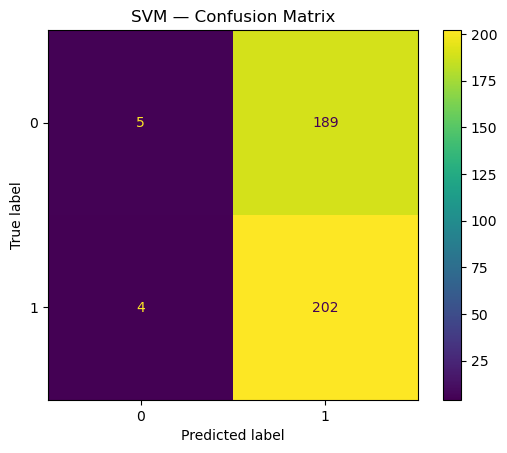


KNN — Best Parameters: {'model__n_neighbors': 7}
              precision    recall  f1-score   support

           0      0.497     0.495     0.496       194
           1      0.527     0.529     0.528       206

    accuracy                          0.512       400
   macro avg      0.512     0.512     0.512       400
weighted avg      0.512     0.512     0.512       400



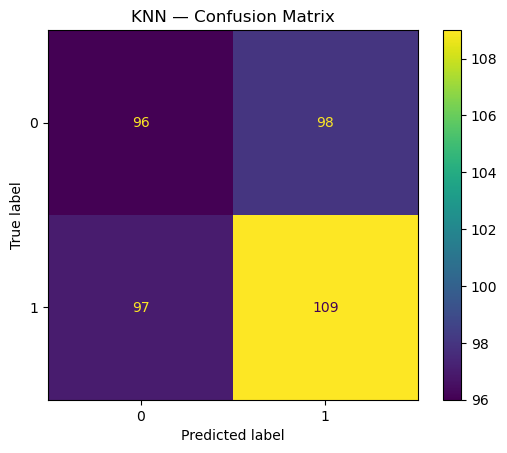


Model Performance Summary:

                 Model                                        Best Params  \
2                  SVM          {'model__C': 0.1, 'model__kernel': 'rbf'}   
6                  SVM          {'model__C': 0.1, 'model__kernel': 'rbf'}   
0  Logistic Regression                                 {'model__C': 0.01}   
4  Logistic Regression                                 {'model__C': 0.01}   
3                  KNN                          {'model__n_neighbors': 7}   
7                  KNN                          {'model__n_neighbors': 7}   
1        Decision Tree  {'model__max_depth': 3, 'model__min_samples_sp...   
5        Decision Tree  {'model__max_depth': 3, 'model__min_samples_sp...   

   Accuracy  Precision    Recall  F1-Score  
2    0.5175   0.516624  0.980583  0.676717  
6    0.5175   0.516624  0.980583  0.676717  
0    0.5125   0.519856  0.699029  0.596273  
4    0.5125   0.519856  0.699029  0.596273  
3    0.5125   0.526570  0.529126  0.527845  
7    0.

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Iterate over classifiers
for name, clf in models.items():
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', clf['model'])
    ])
    
    grid = GridSearchCV(pipe, clf['params'], cv=5, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_val)
    
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    results.append({
        'Model': name,
        'Best Params': grid.best_params_,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    })
    
    # Print the performance metrics
    print(f"\n{name} — Best Parameters: {grid.best_params_}")
    print(classification_report(y_val, y_pred, digits=3))
    
    # Generate and display confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
    disp.plot()
    plt.title(f"{name} — Confusion Matrix")
    plt.show()

# Create a summary table
results_df = pd.DataFrame(results)
print("\nModel Performance Summary:\n")
print(results_df.sort_values(by="F1-Score", ascending=False))

- Top left: True Negative (TN) – Correctly predicted "fake news" (0) as fake news.<br>
- Top right: False Positive (FP) – Incorrectly predicted "real news" (1) when it was actually fake news (0).<br>
- Bottom left: False Negative (FN) – Incorrectly predicted "fake news" (0) when it was actually real news (1).<br>
- Bottom right: True Positive (TP) – Correctly predicted "real news" (1) as real news.<br>


<br>
<br>
SVM still has the highest f1 score, so we will stick with SVM. We can test our model with "new" data using train_test_split in order to help determine if the model can determine if the news is fake or not.

Classification Report (New Test Set):
              precision    recall  f1-score   support

           0      0.459     0.492     0.475       195
           1      0.482     0.449     0.465       205

    accuracy                          0.470       400
   macro avg      0.471     0.471     0.470       400
weighted avg      0.471     0.470     0.470       400



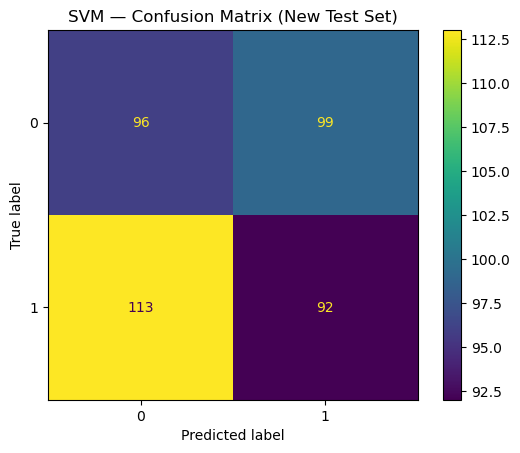

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# First split to create a new test set from the original dataset
# X_train, X_unused, y_train, y_unused = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% for training

# Split the unused subset into validation and new test set
# X_val, X_new, y_val, y_new = train_test_split(X_unused, y_unused, test_size=0.5, random_state=42)

# SVM is already trained on X_train, y_train 
# testing the  model on the "new" data:
y_pred_new = best_model.predict(X_test)

# Evaluate on new test set
print("Classification Report (New Test Set):")
print(classification_report(y_test, y_pred_new, digits=3))

# Generate and display confusion matrix for new testing information
cm_new = confusion_matrix(y_test, y_pred_new)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_new, display_labels=best_model.classes_)
disp.plot()
plt.title("SVM — Confusion Matrix (New Test Set)")
plt.show() ### FIX OVERFITTING, LOW ACCURACY due to dataset is a limitation

- Top left: True Negative (TN) – Correctly predicted "fake news" (1) as fake news.<br>
- Top right: False Positive (FP) – Incorrectly predicted "real news" (0) when it was actually fake news (0).<br>
- Bottom left: False Negative (FN) – Incorrectly predicted "fake news" (1) when it was actually real news (1).<br>
- Bottom right: True Positive (TP) – Correctly predicted "real news" (0) as real news.<br>

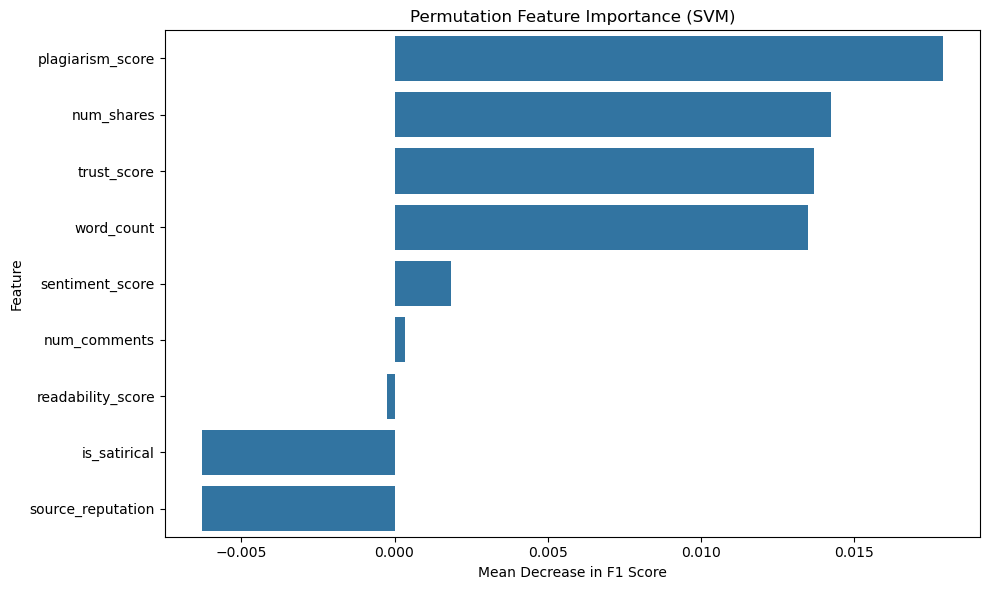

In [20]:
# --- Permutation Feature Importance with SVM ---
# Since SVM (especially with RBF kernel) does not provide native feature importance,
# we use permutation importance to estimate how each feature contributes to the model's performance.
# The idea is to shuffle each feature one at a time and measure the drop in model performance (F1 score).
# A large drop means the feature is important for making correct predictions.

# Apply permutation importance on the validation set
# best_model is the trained SVM model selected based on validation performance
result = permutation_importance(best_model, X_val, y_val, 
                                n_repeats=10, random_state=42, 
                                scoring='f1')  # using F1 score as the evaluation metric

# Organize the results into a DataFrame for better readability
perm_df = pd.DataFrame({
    'feature': X_val.columns,
    'importance_mean': result.importances_mean,  # average drop in F1 score when this feature is permuted
    'importance_std': result.importances_std     # standard deviation across the repeats
}).sort_values(by='importance_mean', ascending=False)

# Visualize the feature importance
plt.figure(figsize=(10,6))
sns.barplot(data=perm_df, x='importance_mean', y='feature')
plt.title("Permutation Feature Importance (SVM)")
plt.xlabel("Mean Decrease in F1 Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


C:\Users\leoxi\AppData\Local\Temp\ipykernel_25460\3855756118.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=category_ratio, x='fake_news_ratio', y='category', palette='coolwarm')


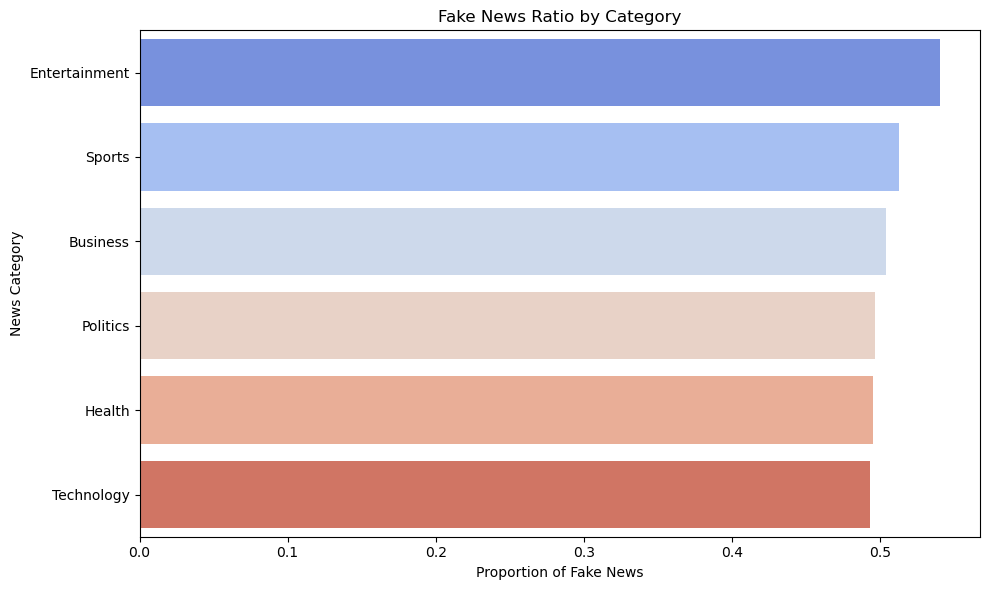

In [21]:
### Are there common topics that are fake or real among the data?


# 1. Group by category and calculate count and fake news ratio (mean of label)
category_ratio = df.groupby('category')['label'].agg(['count', 'mean']).reset_index()
category_ratio.columns = ['category', 'total_articles', 'fake_news_ratio']  # mean(label) = proportion of fake news

# 2. Sort categories by fake news ratio (descending)
category_ratio = category_ratio.sort_values(by='fake_news_ratio', ascending=False)

# 3. Plot fake news ratio by category
plt.figure(figsize=(10, 6))
sns.barplot(data=category_ratio, x='fake_news_ratio', y='category', palette='coolwarm')
plt.title("Fake News Ratio by Category")
plt.xlabel("Proportion of Fake News")
plt.ylabel("News Category")
plt.tight_layout()
plt.show()


C:\Users\leoxi\AppData\Local\Temp\ipykernel_25460\126141676.py:5: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['date_published'] = pd.to_datetime(df['date_published'], errors='coerce')


📅 Date range in dataset:
2020-01-01 00:00:00 to 2024-03-01 00:00:00


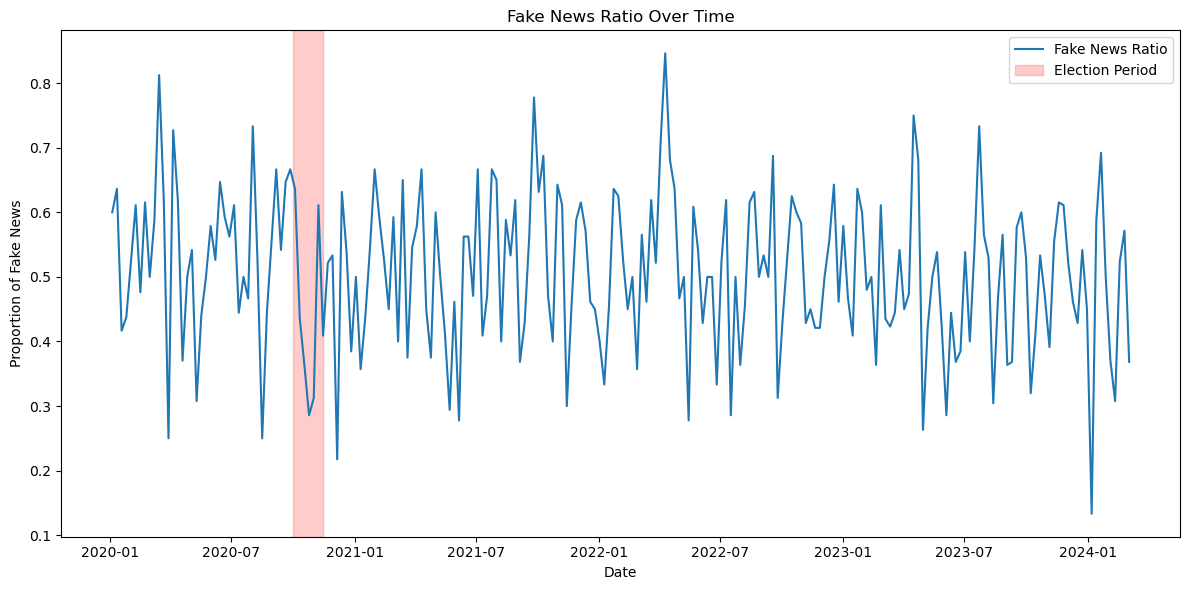

🔍 Average fake news ratio during election: 0.416
📉 Average fake news ratio outside election: 0.509


In [22]:
### What is the relationship of increase in fake news when a political event is occuring?


# 1. Convert date_published to datetime
df['date_published'] = pd.to_datetime(df['date_published'], errors='coerce')

# 2. Check date range
print("📅 Date range in dataset:")
print(df['date_published'].min(), "to", df['date_published'].max())

# 3. Set U.S. election period (example: 2020 election)
election_start = pd.to_datetime('2020-10-01')
election_end = pd.to_datetime('2020-11-15')

# 4. Create a column to indicate if an article was published during election period
df['during_election'] = df['date_published'].between(election_start, election_end)

# 5. Resample data weekly to calculate fake news ratio
df_weekly = df.set_index('date_published').resample('W').agg({
    'label': ['mean', 'count']
})
df_weekly.columns = ['fake_news_ratio', 'total_articles']
df_weekly = df_weekly.reset_index()

# 6. Plot fake news ratio over time with election period highlighted
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_weekly, x='date_published', y='fake_news_ratio', label='Fake News Ratio')
plt.axvspan(election_start, election_end, color='red', alpha=0.2, label='Election Period')
plt.title("Fake News Ratio Over Time")
plt.xlabel("Date")
plt.ylabel("Proportion of Fake News")
plt.legend()
plt.tight_layout()
plt.show()

# 7. Optional: Compare average fake news ratio during vs outside election
avg_during = df[df['during_election']]['label'].mean()
avg_outside = df[~df['during_election']]['label'].mean()

print(f"🔍 Average fake news ratio during election: {avg_during:.3f}")
print(f"📉 Average fake news ratio outside election: {avg_outside:.3f}")

